In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
dir_ = Path('/content/drive/MyDrive/2023 캡스톤디자인/hair2')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/2023 캡스톤디자인/hair2/train...,1_경증
1,/content/drive/MyDrive/2023 캡스톤디자인/hair2/train...,0_양호
2,/content/drive/MyDrive/2023 캡스톤디자인/hair2/train...,3_중증
3,/content/drive/MyDrive/2023 캡스톤디자인/hair2/train...,0_양호
4,/content/drive/MyDrive/2023 캡스톤디자인/hair2/train...,3_중증


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4364 (\N{HANGUL CHOSEONG CIEUC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4462 (\N{HANGUL JUNGSEONG U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4540 (\N{HANGUL JONGSEONG IEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4467 (\N{HANGUL JUNGSEONG EU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4363 (\N{HANGUL CHOSEONG IEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

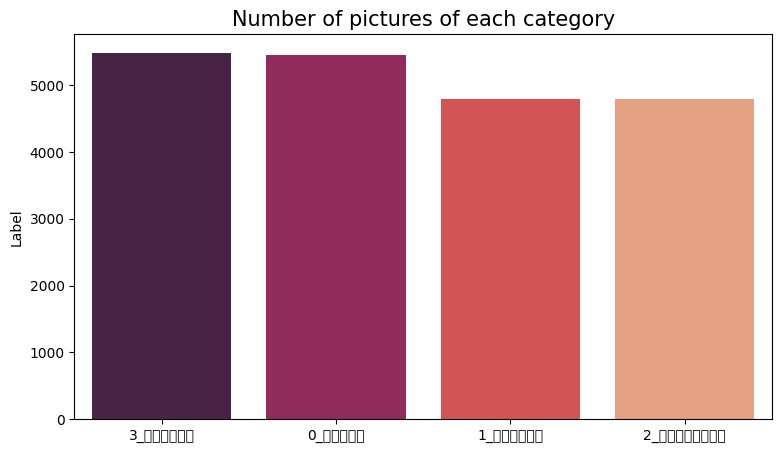

Number of pictures: 20537

Number of different labels: 4

Labels: ['1_경증' '0_양호' '3_중증' '2_중등도']


In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')


<ipython-input-6-66ab412f6692>:8: UserWarning: Glyph 4352 (\N{HANGUL CHOSEONG KIYEOK}) missing from current font.
  plt.tight_layout(pad=0.5)
<ipython-input-6-66ab412f6692>:8: UserWarning: Glyph 4455 (\N{HANGUL JUNGSEONG YEO}) missing from current font.
  plt.tight_layout(pad=0.5)
<ipython-input-6-66ab412f6692>:8: UserWarning: Glyph 4540 (\N{HANGUL JONGSEONG IEUNG}) missing from current font.
  plt.tight_layout(pad=0.5)
<ipython-input-6-66ab412f6692>:8: UserWarning: Glyph 4364 (\N{HANGUL CHOSEONG CIEUC}) missing from current font.
  plt.tight_layout(pad=0.5)
<ipython-input-6-66ab412f6692>:8: UserWarning: Glyph 4467 (\N{HANGUL JUNGSEONG EU}) missing from current font.
  plt.tight_layout(pad=0.5)
<ipython-input-6-66ab412f6692>:8: UserWarning: Glyph 4363 (\N{HANGUL CHOSEONG IEUNG}) missing from current font.
  plt.tight_layout(pad=0.5)
<ipython-input-6-66ab412f6692>:8: UserWarning: Glyph 4451 (\N{HANGUL JUNGSEONG YA}) missing from current font.
  plt.tight_layout(pad=0.5)
<ipython-input-6

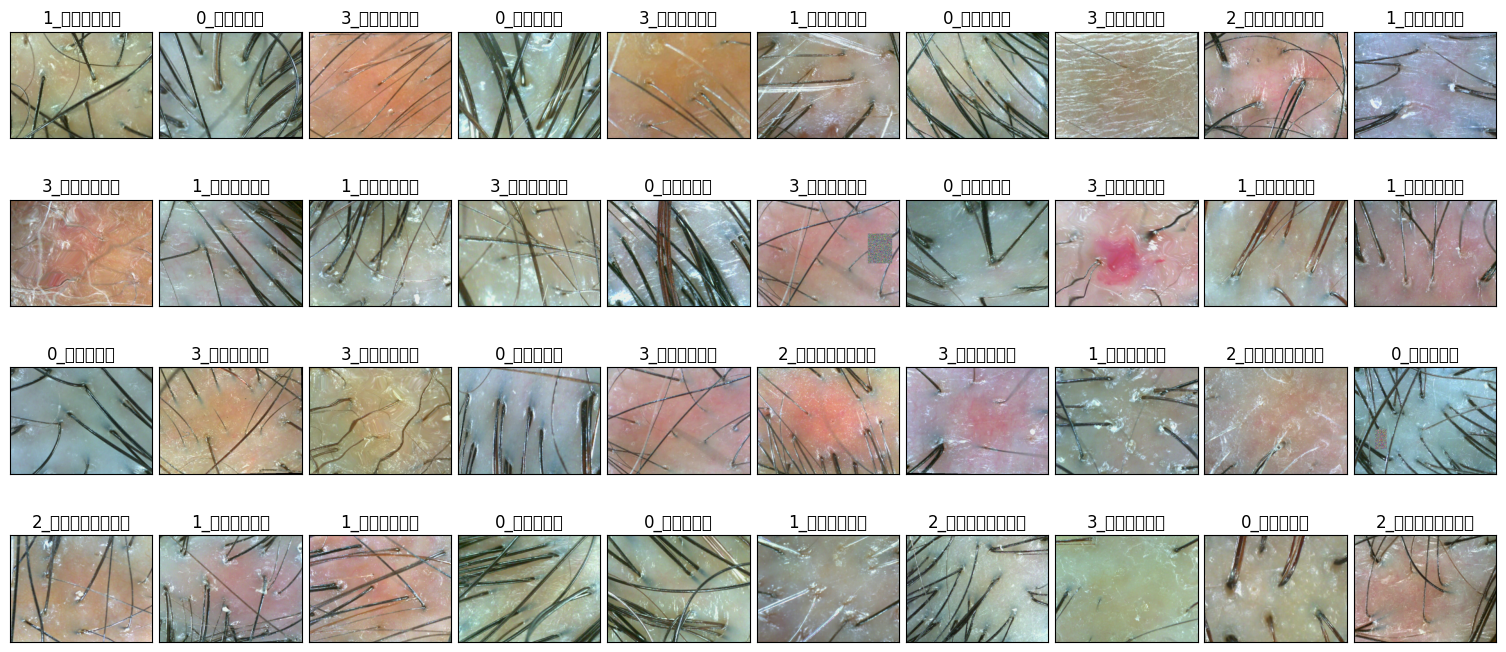

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((18483, 2), (2054, 2))

In [ ]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=20)

Found 16635 validated image filenames belonging to 4 classes.
Found 1848 validated image filenames belonging to 4 classes.
Found 2054 validated image filenames belonging to 4 classes.
Epoch 1/20
520/520 [==============================] - 171s 309ms/step - loss: 0.6956 - accuracy: 0.6920 - val_loss: 0.5898 - val_accuracy: 0.7381
Epoch 2/20
520/520 [==============================] - 156s 299ms/step - loss: 0.5738 - accuracy: 0.7499 - val_loss: 0.5714 - val_accuracy: 0.7440
Epoch 3/20
520/520 [==============================] - 158s 305ms/step - loss: 0.5312 - accuracy: 0.7659 - val_loss: 0.5328 - val_accuracy: 0.7565
Epoch 4/20
520/520 [==============================] - 157s 302ms/step - loss: 0.5023 - accuracy: 0.7786 - val_loss: 0.5510 - val_accuracy: 0.7413
Epoch 5/20
520/520 [==============================] - 156s 299ms/step - loss: 0.4728 - accuracy: 0.7898 - val_loss: 0.5304 - val_accuracy: 0.7679
Epoch 6/20
520/520 [==============================] - 154s 296ms/step - loss: 0.4467 -

In [ ]:
models = {
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
}
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

for name, model in models.items():

    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 16635 validated image filenames belonging to 4 classes.
Found 1848 validated image filenames belonging to 4 classes.
Found 2054 validated image filenames belonging to 4 classes.


74836368/74836368 [==============================] - 4s 0us/step
DenseNet201          trained in 11072.07 sec


In [ ]:
for name, model in models.items():


    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)


    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')


models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

65/65 [==============================] - 1211s 19s/step
**DenseNet201 has a 70.93% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.7197,0.7093,11072.07


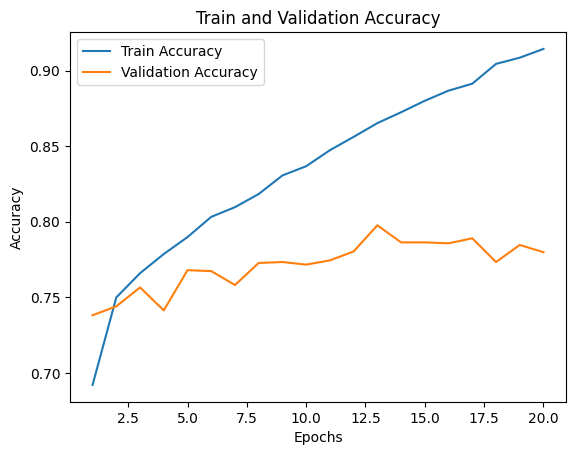

In [ ]:
import matplotlib.pyplot as plt # 모델링 후 추후에 발표를 위해 만들어서 학습결과를 바탕으로 하나하나 직접 대입

epochs = [1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
train_accuracy = [0.6920, 0.7499, 0.7659,0.7786,0.7898,0.8032,0.8096,0.8183,0.8306,0.8367,0.8473,0.8561,0.8652,0.8724,0.8800,0.8867,0.8913,0.9044,0.9085,0.9143]
val_accuracy = [0.7381,0.7440,0.7565,0.7413,0.7679,0.7673,0.7581,0.7727,0.7733,0.7716,0.7744,0.7803,0.7976,0.7863,0.7863,0.7857,0.7890,0.7733,0.7846,0.7798]

plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()